In [1]:
Train_path="/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train"
Test_path="/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test"

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50,VGG19
from keras.layers import Dense,Flatten,Dropout,Input,BatchNormalization,MaxPool2D
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

2025-05-20 14:32:16.097664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747751536.291372      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747751536.352991      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


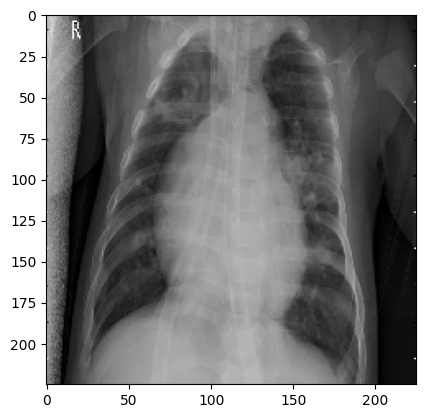

In [3]:
path=Train_path+"/PNEUMONIA"
img_name=os.listdir(path)[100]
image_path=path+"/"+img_name
img=image.load_img(image_path,target_size=(225,225))
plot=plt.imshow(img)

(225, 225, 3)


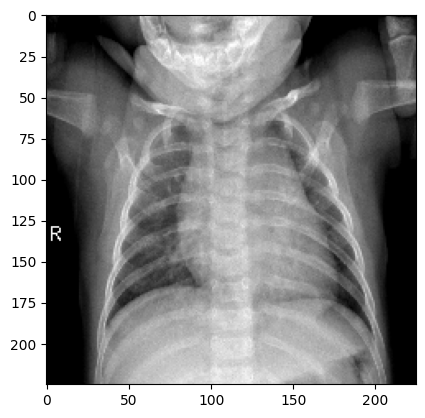

In [4]:
path=Train_path+"/NORMAL"
img_name=os.listdir(path)[100]
image_path=path+"/"+img_name
img=image.load_img(image_path,target_size=(225,225))
imag_arr=image.img_to_array(img)
print(imag_arr.shape)
plot=plt.imshow(img)

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    Train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',  
    subset='training', 
)

validation_generator = train_datagen.flow_from_directory(
    Train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',  
    subset='validation', 
)

test_generator=test_datagen.flow_from_directory(
    Test_path,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
conv_base=VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))
# conv_base.summary()

I0000 00:00:1747751561.174782      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747751561.175417      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
conv_base.trainable=False

In [8]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())

model.add(Dropout(0.2))
model.add(Dense(250,activation='relu'))
model.add(BatchNormalization())



model.add(Dense(1,activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 250)                 │       2,048,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 250)                 │           1,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,073,885 (84.21 MB)

 Trainable params: 2,049,001 (7.82 MB)

 Non-trainable params: 20,024,884 (76.39 MB)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
history=model.fit(train_generator,
                  epochs=50,
                 validation_data=validation_generator
                )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1747751571.089539      85 service.cc:148] XLA service 0x7a5b08007f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747751571.090300      85 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747751571.090319      85 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747751571.598263      85 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/131 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5156 - loss: 0.8833 

I0000 00:00:1747751578.467763      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 114s 795ms/step - accuracy: 0.8122 - loss: 0.4613 - val_accuracy: 0.9148 - val_loss: 0.2230
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 458ms/step - accuracy: 0.9135 - loss: 0.2162 - val_accuracy: 0.9254 - val_loss: 0.2036
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 457ms/step - accuracy: 0.9144 - loss: 0.2086 - val_accuracy: 0.9254 - val_loss: 0.1714
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 456ms/step - accuracy: 0.9150 - loss: 0.2087 - val_accuracy: 0.9416 - val_loss: 0.1483
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 458ms/step - accuracy: 0.9229 - loss: 0.1799 - val_accuracy: 0.9378 - val_loss: 0.1782
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 452ms/step - accuracy: 0.9221 - loss: 0.1832 - val_accuracy: 0.9234 - val_loss: 0.1935
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 458ms/step - accuracy: 0.9229 - loss: 0.1872 - val_accuracy: 0.9368 - val_loss: 0.1634
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 453ms/step - accuracy: 0.9254 - loss: 0.1818 - va

In [12]:
res=model.evaluate(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 705ms/step - accuracy: 0.9073 - loss: 0.2761


In [13]:
res[1]

0.9038461446762085

In [14]:
y_pred= model.predict(test_generator)
y_pred

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step


array([[1.76735505e-01],
       [2.27869675e-01],
       [3.08470428e-01],
       [9.99443829e-01],
       [9.98131812e-01],
       [9.99733984e-01],
       [9.95626211e-01],
       [1.95336998e-01],
       [9.45365369e-01],
       [9.85114098e-01],
       [8.43213219e-03],
       [1.30382672e-01],
       [9.98439848e-01],
       [9.98134971e-01],
       [9.96444166e-01],
       [9.98420358e-01],
       [9.99598444e-01],
       [1.89381137e-01],
       [2.76436401e-03],
       [3.08892820e-02],
       [9.31320846e-01],
       [1.47220656e-01],
       [9.98952031e-01],
       [1.33282384e-02],
       [2.63881773e-01],
       [2.33572528e-01],
       [6.10809103e-02],
       [9.96139705e-01],
       [9.91056323e-01],
       [9.99827385e-01],
       [9.53930140e-01],
       [9.95386302e-01],
       [9.99312997e-01],
       [6.39373720e-01],
       [9.99710739e-01],
       [4.00740415e-01],
       [4.65610862e-01],
       [5.04143953e-01],
       [8.20319593e-01],
       [9.99089837e-01],


In [15]:
import numpy as np
y_true = test_generator.classes
y_pred_classes = np.argmax(y_pred, axis=1)


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred_classes)


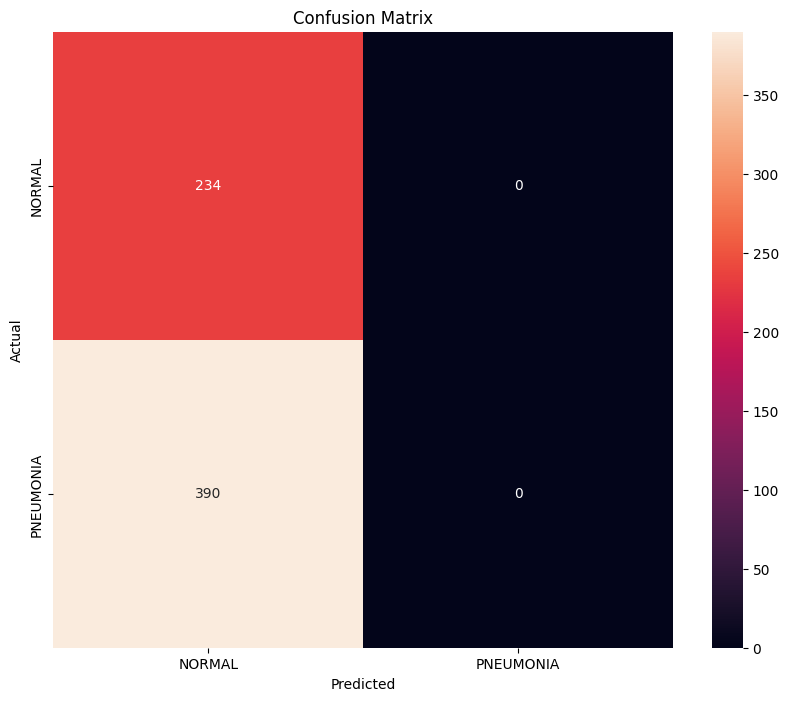

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()